<a href="https://colab.research.google.com/github/lmtkhanh/Week-2_Data_Preprocessing/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importing necessary Python version and Libraries**

In [ ]:
!python3 -m pip --version
!pip install soundfile

pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [8]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install numpy
#!pip install opencv-python
#!pip install nltk
#!pip install librosa

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import nltk
import librosa

### **Feature Extraction**

In [10]:
# Get the critical imports out of the way
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML
# Center matplotlib figures...
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [11]:
import librosa

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    #print(stft_spectrogram.shape)
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    #print(chromagram.shape)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

In [12]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)
        feature_matrix=np.array([])

        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

### **Loading Audio from RAVDESS (Emotions)**

In [13]:
import os, glob
import numpy as np
import soundfile

common_emotions = {
    '01': 'neutral',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust'
}


def load_ravdess_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/IAT 481/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion_code = file_name.split("-")[2]
        #Only load the emotion shared by 2 datasets
        if emotion_code in common_emotions:
          emotionR = common_emotions[emotion_code]
          featuresR = get_features(file)
          X.append(featuresR)
          y.append(emotionR)
          count += 1

         # '\r' + end='' results in printing over same line
          print('\r' + f' Processed {count}/{1435} audio samples',end=' ')
      # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

In [14]:
featuresR, emotionR = load_ravdess_data()

 Processed 1054/1435 audio samples 

In [15]:
print(f'\nAudio samples represented: {featuresR.shape[0]}')
print(f'Numerical features extracted per sample: {featuresR.shape[1]}')
featuresR_df = pd.DataFrame(featuresR) # make it pretty for display
featuresR_df


Audio samples represented: 1054
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.636684,0.628297,0.631292,0.651613,0.698669,0.767675,0.781398,0.741129,0.741146,0.705466,...,-1.673998,-0.503829,0.026309,0.215442,1.812259,2.770561,1.646000,2.532423,0.569808,1.190669
1,0.619704,0.639446,0.650099,0.693850,0.721269,0.756798,0.789992,0.768492,0.766670,0.698196,...,-1.135965,-0.554937,-1.294901,-0.990536,-0.618531,0.289876,-0.120279,0.519724,1.181626,2.576108
2,0.615388,0.598130,0.632746,0.687002,0.735016,0.746685,0.735427,0.738268,0.771911,0.697520,...,-3.166279,0.292470,-1.585585,-0.819369,-1.223765,0.182237,0.581931,2.988665,3.700677,4.860653
3,0.666090,0.641014,0.625757,0.668821,0.702518,0.748449,0.786031,0.716457,0.713515,0.666831,...,-1.627202,1.990687,1.660290,1.184242,1.871421,1.095554,0.522881,0.699638,0.359175,1.215944
4,0.601642,0.617534,0.665111,0.690098,0.711811,0.743393,0.746468,0.811313,0.819656,0.768950,...,-1.931422,0.705211,-1.421736,0.109918,0.826748,3.198303,3.540084,4.285282,5.466786,6.817317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,0.714570,0.642242,0.599776,0.559592,0.535722,0.593334,0.677825,0.642308,0.637836,0.697389,...,4.606691,7.415055,5.400178,2.796613,5.055417,3.130010,0.871994,0.887742,-0.218687,1.141505
1050,0.558261,0.633760,0.607081,0.564991,0.606804,0.697466,0.776295,0.745406,0.698547,0.687153,...,-3.290008,-4.192609,-2.975512,-1.233714,-1.482003,-2.032330,0.065089,-0.486623,-0.640735,-0.860338
1051,0.626034,0.594640,0.617562,0.573329,0.557500,0.615959,0.686903,0.675111,0.661743,0.663048,...,3.803571,3.034509,2.019023,0.320287,1.755269,1.537050,0.793371,2.439653,-1.614806,-0.646167
1052,0.600810,0.569928,0.585620,0.623596,0.645769,0.695486,0.685356,0.638389,0.611997,0.660883,...,0.920214,2.389385,0.042414,-0.168045,1.884149,0.347379,-0.083077,1.599976,0.338264,-0.604630


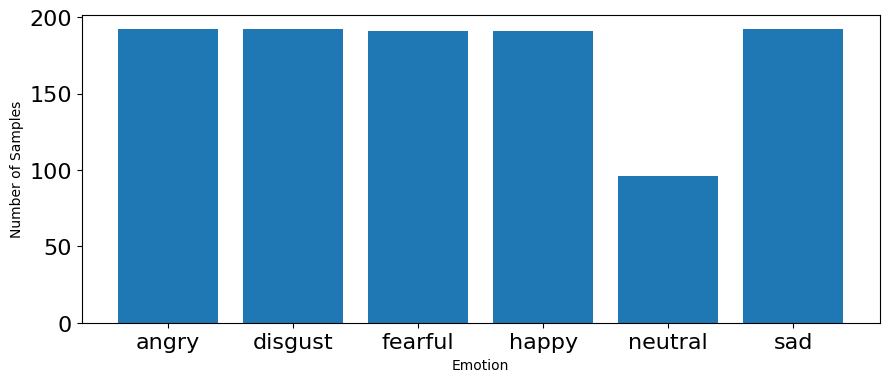

In [16]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotionR, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list], fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

### **Loading Audio from EMODB (Emotions)**

In [17]:
import os, glob
import numpy as np
import soundfile

common_emotions = {
    'N': 'neutral',
    'F': 'happy',
    'T': 'sad',
    'W': 'angry',
    'A': 'fearful',
    'E': 'disgust'
}


def load_emodb_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/IAT 481/EmoDB/*.wav"):
        file_name=os.path.basename(file)
        emotion_code = file_name[5]
        #Only load the emotion shared by 2 datasets
        if emotion_code in common_emotions:
          emotionE = common_emotions[emotion_code]
          featuresE = get_features(file)
          X.append(featuresE)
          y.append(emotionE)
          count += 1

         # '\r' + end='' results in printing over same line
          print('\r' + f' Processed {count}/{535} audio samples',end=' ')
      # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

In [18]:
featuresE, emotionE = load_emodb_data()

 Processed 454/535 audio samples 

In [19]:
print(f'\nAudio samples represented: {featuresE.shape[0]}')
print(f'Numerical features extracted per sample: {featuresE.shape[1]}')
featuresE_df = pd.DataFrame(featuresE) # make it pretty for display
featuresE_df


Audio samples represented: 454
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.551519,0.497329,0.518016,0.575646,0.631912,0.685601,0.644916,0.632489,0.635610,0.675823,...,1.244440,2.327929,-0.604429,3.734100,1.145658,3.809346,3.586081,2.798713,2.782395,1.144741
1,0.607800,0.584315,0.631464,0.691069,0.665198,0.668158,0.644499,0.628710,0.646426,0.635522,...,-3.324037,-1.364126,-2.830347,-1.963027,-1.468808,-1.079737,-0.682392,-1.925796,-0.824300,-1.035421
2,0.720641,0.720583,0.617265,0.595652,0.606965,0.608982,0.657078,0.695031,0.698287,0.615263,...,-1.645359,-2.420688,-2.502800,-3.199017,-2.187031,-3.741765,-2.143440,-2.468618,-1.887268,-2.429971
3,0.404909,0.515188,0.558104,0.571996,0.608146,0.599661,0.510465,0.428739,0.506934,0.575784,...,0.870254,1.566974,2.292184,3.129890,1.996737,0.305314,-0.157051,3.427973,1.873118,-0.783700
4,0.512014,0.585578,0.589255,0.581887,0.606004,0.661837,0.657070,0.611554,0.600824,0.648380,...,0.134079,2.586298,3.310400,3.682724,2.295565,-0.075023,-0.012579,3.551004,0.059484,3.154512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,0.545511,0.604831,0.644693,0.675429,0.716208,0.726433,0.676241,0.672165,0.674903,0.716056,...,-2.045649,-1.179349,-2.833190,-1.940967,-2.509913,-2.486703,-3.354582,-1.943447,-1.464825,-2.969693
450,0.498928,0.451786,0.517057,0.605375,0.563523,0.537695,0.497537,0.484230,0.511041,0.603973,...,5.097405,1.399691,-2.035277,0.764548,2.037185,0.918335,-0.946199,-1.225412,0.948814,5.614808
451,0.479394,0.504327,0.587494,0.613058,0.626845,0.626645,0.578185,0.491933,0.457327,0.462098,...,-2.463939,1.045352,-0.204357,2.378903,-1.186556,0.181454,1.126310,1.671440,1.369183,0.590503
452,0.481175,0.437888,0.420873,0.488118,0.562618,0.604745,0.576610,0.624957,0.663843,0.650717,...,7.207660,4.627536,3.303271,3.778844,2.242899,1.586491,-0.263002,0.830273,0.451080,-0.407189


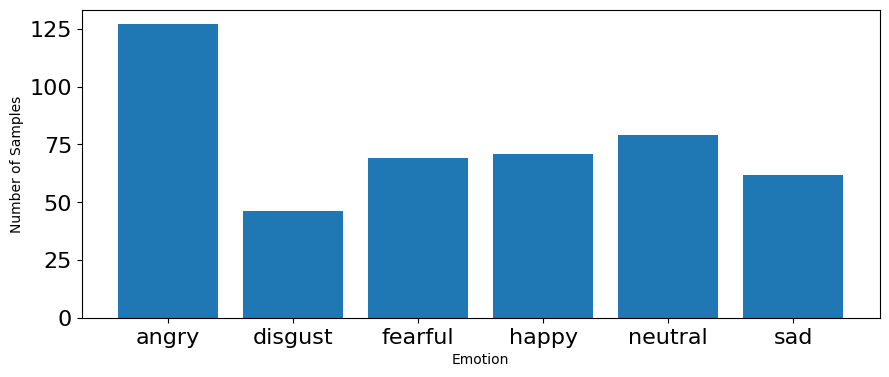

In [20]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotionE, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list], fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

### **Merging two feature matrices (Emotions)**

In [21]:
# Merge the feature matrices
features_combined = np.concatenate((featuresR, featuresE), axis=0)

# Merge the label arrays
emotion_combined = np.concatenate((emotionR, emotionE), axis=0)

In [22]:
print(f'\nAudio samples represented: {features_combined.shape[0]}')
print(f'Numerical features extracted per sample: {features_combined.shape[1]}')
features_combined_df = pd.DataFrame(features_combined) # make it pretty for display
features_combined_df


Audio samples represented: 1508
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.636684,0.628297,0.631292,0.651613,0.698669,0.767675,0.781398,0.741129,0.741146,0.705466,...,-1.673998,-0.503829,0.026309,0.215442,1.812259,2.770561,1.646000,2.532423,0.569808,1.190669
1,0.619704,0.639446,0.650099,0.693850,0.721269,0.756798,0.789992,0.768492,0.766670,0.698196,...,-1.135965,-0.554937,-1.294901,-0.990536,-0.618531,0.289876,-0.120279,0.519724,1.181626,2.576108
2,0.615388,0.598130,0.632746,0.687002,0.735016,0.746685,0.735427,0.738268,0.771911,0.697520,...,-3.166279,0.292470,-1.585585,-0.819369,-1.223765,0.182237,0.581931,2.988665,3.700677,4.860653
3,0.666090,0.641014,0.625757,0.668821,0.702518,0.748449,0.786031,0.716457,0.713515,0.666831,...,-1.627202,1.990687,1.660290,1.184242,1.871421,1.095554,0.522881,0.699638,0.359175,1.215944
4,0.601642,0.617534,0.665111,0.690098,0.711811,0.743393,0.746468,0.811313,0.819656,0.768950,...,-1.931422,0.705211,-1.421736,0.109918,0.826748,3.198303,3.540084,4.285282,5.466786,6.817317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.545511,0.604831,0.644693,0.675429,0.716208,0.726433,0.676241,0.672165,0.674903,0.716056,...,-2.045649,-1.179349,-2.833190,-1.940967,-2.509913,-2.486703,-3.354582,-1.943447,-1.464825,-2.969693
1504,0.498928,0.451786,0.517057,0.605375,0.563523,0.537695,0.497537,0.484230,0.511041,0.603973,...,5.097405,1.399691,-2.035277,0.764548,2.037185,0.918335,-0.946199,-1.225412,0.948814,5.614808
1505,0.479394,0.504327,0.587494,0.613058,0.626845,0.626645,0.578185,0.491933,0.457327,0.462098,...,-2.463939,1.045352,-0.204357,2.378903,-1.186556,0.181454,1.126310,1.671440,1.369183,0.590503
1506,0.481175,0.437888,0.420873,0.488118,0.562618,0.604745,0.576610,0.624957,0.663843,0.650717,...,7.207660,4.627536,3.303271,3.778844,2.242899,1.586491,-0.263002,0.830273,0.451080,-0.407189


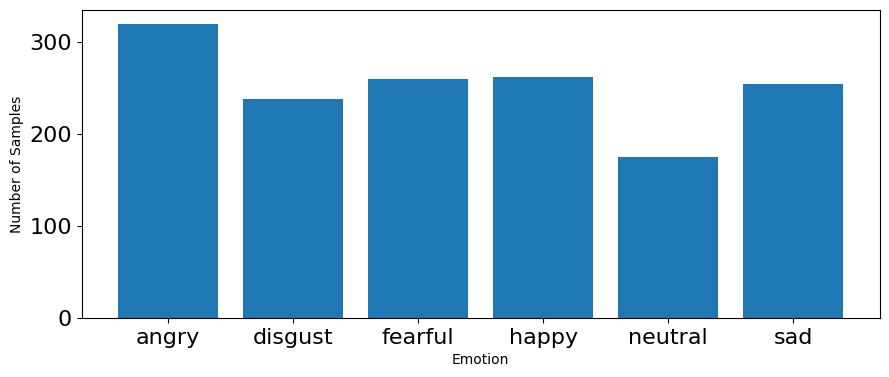

In [23]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotion_combined, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list], fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

### **Loading Audio from RAVDESS (Gender)**

In [25]:
import os, glob
import numpy as np
import soundfile


def load_ravdess_data_gender():
    X, y = [], []
    count = 0
    for file in glob.glob("/content/drive/MyDrive/IAT 481/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        #Retrieving the last identifier in the file name that indicate gender
        actor_id = int(file_name.split("-")[-1].split(".")[0])

        # Odd numbered actors are male, even numbered are female
        if actor_id % 2 != 0:
          gender = 'male'
        else:
          gender = 'female'

        featuresR_gender = get_features(file)
        X.append(featuresR_gender)
        y.append(gender)
        count += 1
        print('\r' + f' Processed {count}/{1435} audio samples',end=' ')
    return np.array(X), np.array(y)

featuresR_gender, genderR = load_ravdess_data_gender()

 Processed 1435/1435 audio samples 

In [27]:
print(f'\nAudio samples represented: {featuresR_gender.shape[0]}')
print(f'Numerical features extracted per sample: {featuresR_gender.shape[1]}')
featuresR_gender_df = pd.DataFrame(featuresR_gender) # make it pretty for display
featuresR_gender_df


Audio samples represented: 1435
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.636684,0.628297,0.631292,0.651613,0.698669,0.767675,0.781398,0.741129,0.741146,0.705466,...,-1.673998,-0.503829,0.026309,0.215442,1.812259,2.770561,1.646000,2.532423,0.569808,1.190669
1,0.625121,0.626941,0.644533,0.669413,0.709200,0.768898,0.820867,0.793139,0.744958,0.673990,...,-1.633773,0.835018,-0.569775,0.810085,0.722037,1.965551,0.605444,-0.445064,-0.024760,0.520185
2,0.619704,0.639446,0.650099,0.693850,0.721269,0.756798,0.789992,0.768492,0.766670,0.698196,...,-1.135965,-0.554937,-1.294901,-0.990536,-0.618531,0.289876,-0.120279,0.519724,1.181626,2.576108
3,0.615388,0.598130,0.632746,0.687002,0.735016,0.746685,0.735427,0.738268,0.771911,0.697520,...,-3.166279,0.292470,-1.585585,-0.819369,-1.223765,0.182237,0.581931,2.988665,3.700677,4.860653
4,0.666090,0.641014,0.625757,0.668821,0.702518,0.748449,0.786031,0.716457,0.713515,0.666831,...,-1.627202,1.990687,1.660290,1.184242,1.871421,1.095554,0.522881,0.699638,0.359175,1.215944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,0.626034,0.594640,0.617562,0.573329,0.557500,0.615959,0.686903,0.675111,0.661743,0.663048,...,3.803571,3.034509,2.019023,0.320287,1.755269,1.537050,0.793371,2.439653,-1.614806,-0.646167
1431,0.600810,0.569928,0.585620,0.623596,0.645769,0.695486,0.685356,0.638389,0.611997,0.660883,...,0.920214,2.389385,0.042414,-0.168045,1.884149,0.347379,-0.083077,1.599976,0.338264,-0.604630
1432,0.622948,0.632110,0.605948,0.613460,0.666595,0.707086,0.711098,0.683693,0.700959,0.716277,...,-0.524714,-0.630568,-1.465338,1.299774,3.187306,0.838335,2.446721,2.531282,1.364833,1.820621
1433,0.602103,0.595779,0.641031,0.655105,0.700911,0.776305,0.719002,0.627122,0.616481,0.635094,...,-1.258803,-4.592623,-3.247047,-3.589799,-3.859288,-2.832181,-2.228039,-1.752504,-1.885772,-2.215211


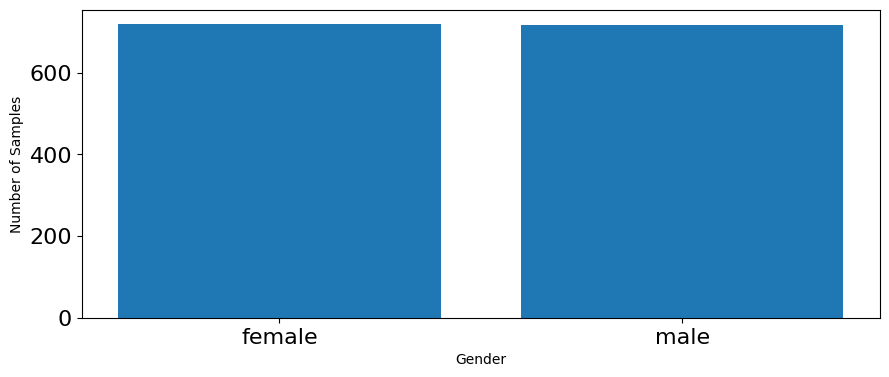

In [31]:
# plot gender
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
gender_list, count = np.unique(genderR, return_counts=True)
plt.bar(x=range(2), height=count)
plt.xticks(ticks=range(2), labels = gender_list, fontsize=10)
plt.xlabel('Gender')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

### **Loading Audio from EMODB (Gender)**

In [34]:
import os, glob
import numpy as np
import soundfile

speaker_gender = {
    '03': 'male', '08': 'female', '09': 'female', '10': 'male',
    '11': 'male', '12': 'male', '13': 'female', '14': 'female',
    '15': 'male', '16': 'female'
}

def load_emodb_data_gender():
    X, y = [], []
    count = 0
    for file in glob.glob("/content/drive/MyDrive/IAT 481/EmoDB/*.wav"):
        file_name = os.path.basename(file)

        #Get the first two number that indicate gender
        speaker_code = file_name[:2]
        gender = speaker_gender[speaker_code]
        featuresE_gender = get_features(file)
        X.append(featuresE_gender)
        y.append(gender)
        count += 1
        print('\r' + f'Processed {count}/535 EmoDB audio samples', end=' ')
    return np.array(X), np.array(y)

featuresE_gender, genderE = load_emodb_data_gender()

Processed 535/535 EmoDB audio samples 

In [35]:
print(f'\nAudio samples represented: {featuresE_gender.shape[0]}')
print(f'Numerical features extracted per sample: {featuresE_gender.shape[1]}')
featuresE_gender_df = pd.DataFrame(featuresE_gender) # make it pretty for display
featuresE_gender_df


Audio samples represented: 535
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.551519,0.497329,0.518016,0.575646,0.631912,0.685601,0.644916,0.632489,0.635610,0.675823,...,1.244440,2.327929,-0.604429,3.734100,1.145658,3.809346,3.586081,2.798713,2.782395,1.144741
1,0.607800,0.584315,0.631464,0.691069,0.665198,0.668158,0.644499,0.628710,0.646426,0.635522,...,-3.324037,-1.364126,-2.830347,-1.963027,-1.468808,-1.079737,-0.682392,-1.925796,-0.824300,-1.035421
2,0.720641,0.720583,0.617265,0.595652,0.606965,0.608982,0.657078,0.695031,0.698287,0.615263,...,-1.645359,-2.420688,-2.502800,-3.199017,-2.187031,-3.741765,-2.143440,-2.468618,-1.887268,-2.429971
3,0.404909,0.515188,0.558104,0.571996,0.608146,0.599661,0.510465,0.428739,0.506934,0.575784,...,0.870254,1.566974,2.292184,3.129890,1.996737,0.305314,-0.157051,3.427973,1.873118,-0.783700
4,0.512014,0.585578,0.589255,0.581887,0.606004,0.661837,0.657070,0.611554,0.600824,0.648380,...,0.134079,2.586298,3.310400,3.682724,2.295565,-0.075023,-0.012579,3.551004,0.059484,3.154512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,0.545511,0.604831,0.644693,0.675429,0.716208,0.726433,0.676241,0.672165,0.674903,0.716056,...,-2.045649,-1.179349,-2.833190,-1.940967,-2.509913,-2.486703,-3.354582,-1.943447,-1.464825,-2.969693
531,0.498928,0.451786,0.517057,0.605375,0.563523,0.537695,0.497537,0.484230,0.511041,0.603973,...,5.097405,1.399691,-2.035277,0.764548,2.037185,0.918335,-0.946199,-1.225412,0.948814,5.614808
532,0.479394,0.504327,0.587494,0.613058,0.626845,0.626645,0.578185,0.491933,0.457327,0.462098,...,-2.463939,1.045352,-0.204357,2.378903,-1.186556,0.181454,1.126310,1.671440,1.369183,0.590503
533,0.481175,0.437888,0.420873,0.488118,0.562618,0.604745,0.576610,0.624957,0.663843,0.650717,...,7.207660,4.627536,3.303271,3.778844,2.242899,1.586491,-0.263002,0.830273,0.451080,-0.407189


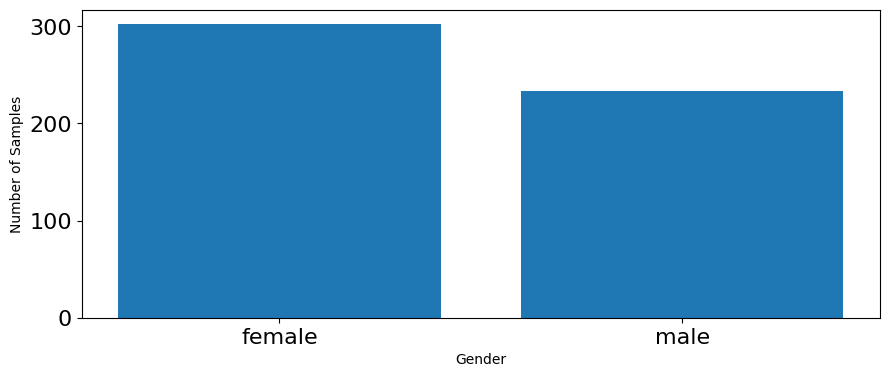

In [36]:
# plot gender
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
gender_list, count = np.unique(genderE, return_counts=True)
plt.bar(x=range(2), height=count)
plt.xticks(ticks=range(2), labels = gender_list, fontsize=10)
plt.xlabel('Gender')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

### **Merging two feature matrices (Gender)**


In [37]:
# Merge the feature matrices
features_gender_combined = np.concatenate((featuresR_gender, featuresE_gender), axis=0)

# Merge the label arrays
gender_combined = np.concatenate((genderR, genderE), axis=0)

In [38]:
print(f'\nAudio samples represented: {features_gender_combined.shape[0]}')
print(f'Numerical features extracted per sample: {features_gender_combined.shape[1]}')
features_gender_combined_df = pd.DataFrame(features_gender_combined) # make it pretty for display
features_gender_combined_df


Audio samples represented: 1970
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.636684,0.628297,0.631292,0.651613,0.698669,0.767675,0.781398,0.741129,0.741146,0.705466,...,-1.673998,-0.503829,0.026309,0.215442,1.812259,2.770561,1.646000,2.532423,0.569808,1.190669
1,0.625121,0.626941,0.644533,0.669413,0.709200,0.768898,0.820867,0.793139,0.744958,0.673990,...,-1.633773,0.835018,-0.569775,0.810085,0.722037,1.965551,0.605444,-0.445064,-0.024760,0.520185
2,0.619704,0.639446,0.650099,0.693850,0.721269,0.756798,0.789992,0.768492,0.766670,0.698196,...,-1.135965,-0.554937,-1.294901,-0.990536,-0.618531,0.289876,-0.120279,0.519724,1.181626,2.576108
3,0.615388,0.598130,0.632746,0.687002,0.735016,0.746685,0.735427,0.738268,0.771911,0.697520,...,-3.166279,0.292470,-1.585585,-0.819369,-1.223765,0.182237,0.581931,2.988665,3.700677,4.860653
4,0.666090,0.641014,0.625757,0.668821,0.702518,0.748449,0.786031,0.716457,0.713515,0.666831,...,-1.627202,1.990687,1.660290,1.184242,1.871421,1.095554,0.522881,0.699638,0.359175,1.215944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,0.545511,0.604831,0.644693,0.675429,0.716208,0.726433,0.676241,0.672165,0.674903,0.716056,...,-2.045649,-1.179349,-2.833190,-1.940967,-2.509913,-2.486703,-3.354582,-1.943447,-1.464825,-2.969693
1966,0.498928,0.451786,0.517057,0.605375,0.563523,0.537695,0.497537,0.484230,0.511041,0.603973,...,5.097405,1.399691,-2.035277,0.764548,2.037185,0.918335,-0.946199,-1.225412,0.948814,5.614808
1967,0.479394,0.504327,0.587494,0.613058,0.626845,0.626645,0.578185,0.491933,0.457327,0.462098,...,-2.463939,1.045352,-0.204357,2.378903,-1.186556,0.181454,1.126310,1.671440,1.369183,0.590503
1968,0.481175,0.437888,0.420873,0.488118,0.562618,0.604745,0.576610,0.624957,0.663843,0.650717,...,7.207660,4.627536,3.303271,3.778844,2.242899,1.586491,-0.263002,0.830273,0.451080,-0.407189


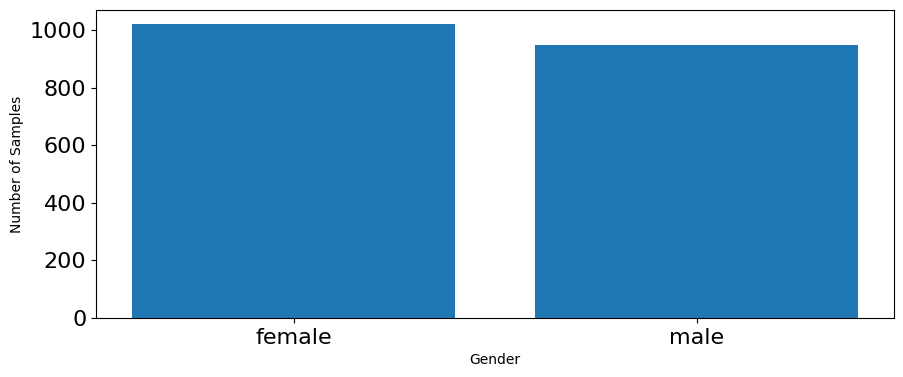

In [39]:
# plot gender
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
gender_list, count = np.unique(gender_combined, return_counts=True)
plt.bar(x=range(2), height=count)
plt.xticks(ticks=range(2), labels = gender_list, fontsize=10)
plt.xlabel('Gender')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()